# Experiment 3: Trained the network with 5 subjects at aspect angle 0 degree then tested on the 6th subject at aspect angles 0, 30, 45 and 60 degrees



*   Trained with 5 subjects at aspect angle 0 degrees
*   Tested on the 6th subject for 0, 30, 45 and 60 degrees
*   Modified from original paper to not validate on every test set for each epoch as Keras does not provide this functionality
*   **Possibly no walking?** **Wrong 0degrees test data**


## Notebook setup

Allow editing of modules using editor (auto reloading)

In [0]:
# Needed to allow editing using PyCharm
%load_ext autoreload
%autoreload 2

Needed for compatibility when using both CoLab and Local Jupyter notebook. It sets the appropriate file path for the data and also installs local packages such as models and data_loading.

In [3]:
import os
if os.getcwd() == '/content':
    from google.colab import drive
    drive.mount('/content/gdrive')
    BASE_PATH = '/content/gdrive/My Drive/Level-4-Project/'
    !cd gdrive/My\ Drive/Level-4-Project/ && pip install --editable .
    os.chdir('gdrive/My Drive/Level-4-Project/')
    
else:
    BASE_PATH = "C:/Users/macka/Google Drive/Level-4-Project/"
    
DATA_PATH = BASE_PATH + 'data/'
MODEL_PATH = BASE_PATH + 'models/original_experiments/experiment_3/'
FIGURE_PATH = BASE_PATH + 'reports/figures/original_experiments/experiment_3/'
REPORT_PATH = BASE_PATH + 'reports/original_experiments/experiment_3/'
    
from src.models.original_models import cnn_64_128
from src.data import load_data
from src.visualization import visualize

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
Obtaining file:///content/gdrive/My%20Drive/Level-4-Project
  Running setup.py develop for src


Using TensorFlow backend.


Import remaining packages

In [0]:
import numpy as np
import sys
from six.moves import cPickle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.utils import np_utils
import sys
from sklearn.metrics import classification_report,confusion_matrix
import csv
from keras.models import load_model

In [0]:
# Needed as originally code was for theano backend but now using tensor flow
from keras import backend as K
K.set_image_dim_ordering('th')

## Experiment Setup and Parameter Definition

In [0]:
data_folders = {'mixed_angle_A':{}, 'cifar_30deg':{}, 'cifar_45deg':{}, 'cifar_60deg':{}}
for key, value in data_folders.items():
    value["acc"] = None
    value["loss"] = None
    value["classification_report"] = None
    value["confusion_matrix"] = None
    
target_names = ['ArmFasterTowards', 'ArmSlowerTowards', 'CirclingArm', 'Clapping', 'PickingUp', 'Sitting']

In [0]:
load_model = False

batch_size = 100
nb_classes = 6
nb_epoch = 100
nb_epoch = 3
nb_train_samples = 34260

# input image dimensions
img_rows, img_cols = 75, 75
# the CIFAR10 images are RGB

In [0]:
# the data, shuffled and split between train and test sets
(X_train, y_train), (X_test, y_test) = load_data.load_data((DATA_PATH + 'cifar_30deg'), nb_train_samples)
Y_train = np_utils.to_categorical(y_train, nb_classes)

In [0]:
if load_model:
    model = load_model(MODEL_PATH + "cnn_64_128.h5")
else:
    model = cnn_64_128.make_model(img_rows, img_cols, nb_classes)

## Training and Evaluating Models

### Train

In [11]:
# Train the model using SGD + momentum.
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

X_train = X_train.astype('float32')
X_train /= 255

history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    shuffle=True, 
    verbose=1)

Epoch 1/3
34260/34260 [==============================] - 69s 2ms/step - loss: 0.5518 - acc: 0.7808
Epoch 2/3
34260/34260 [==============================] - 65s 2ms/step - loss: 0.0931 - acc: 0.9684
Epoch 3/3
34260/34260 [==============================] - 65s 2ms/step - loss: 0.0477 - acc: 0.9840


### Evaluate for each Aspect Angle

In [12]:
for folder_name, value in data_folders.items():    
    X_test, y_test = load_data.load_batch(DATA_PATH + folder_name + '/test_batch')
    y_test = np.reshape(y_test, (len(y_test), 1))
    Y_test = np_utils.to_categorical(y_test, nb_classes)
    print(folder_name)
    evaluation = model.evaluate(X_test, Y_test, batch_size=batch_size, verbose=1)
    value["loss"] = evaluation[0]
    value["accuracy"] = evaluation[1]

    y_pred = model.predict_classes(X_test)
    value["classification_report"] = classification_report(
        np.argmax(Y_test,axis=1),
        y_pred,target_names=target_names)
    value["confusion_matrix"] = confusion_matrix(
        np.argmax(Y_test,axis=1), y_pred)

mixed_angle_A
8690/8690 [==============================] - 6s 733us/step


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cifar_30deg
6852/6852 [==============================] - 5s 701us/step
cifar_45deg
6852/6852 [==============================] - 4s 656us/step
cifar_60deg
6852/6852 [==============================] - 4s 654us/step


## Analysis and Saving of Results

### Plot and Save graphs

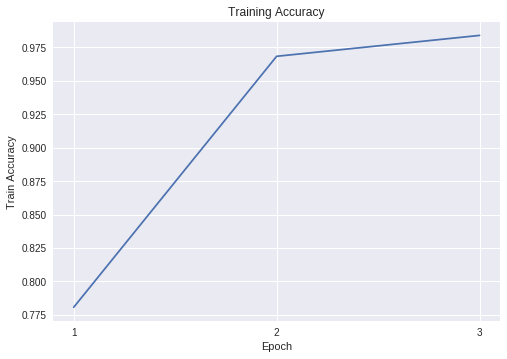

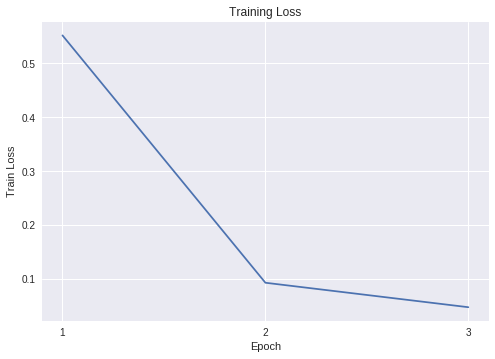

In [46]:
visualize.plot_train_acc(
    history, "Training Accuracy", save=True,
    path=FIGURE_PATH + "model_train_accuracy.svg")
visualize.plot_train_loss(
    history, "Training Loss", save=True,
    path=FIGURE_PATH + "model_train_loss.svg")

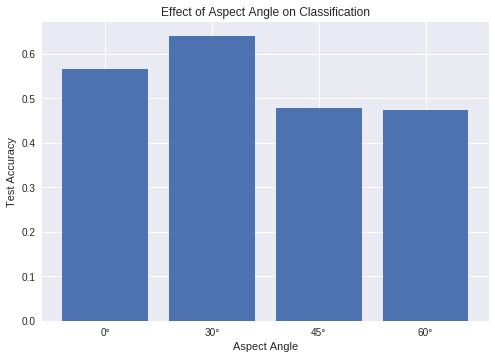

In [38]:
visualize.plot_evaluation_bar(
    data_folders,
    ['0°','30°', '45°', '60°'],
    "Effect of Aspect Angle on Classification",
    'Aspect Angle',
    'Test Accuracy',
    save=True,
    path=FIGURE_PATH + "accuracy.svg")

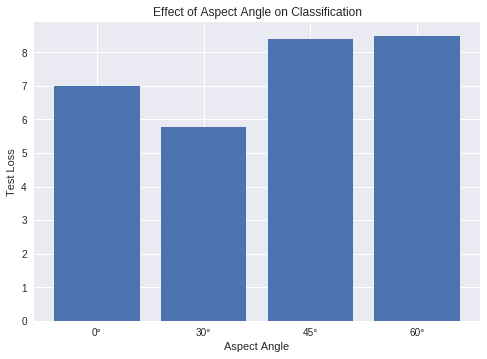

In [39]:
visualize.plot_evaluation_bar(
    data_folders,
    ['0°','30°', '45°', '60°'],
    "Effect of Aspect Angle on Classification",
    'Aspect Angle',
    'Test Loss',
    metric="loss",
    save=True,
    path=FIGURE_PATH + "loss.svg")

### Save Model

In [0]:
if not load_model:
    model.save(MODEL_PATH + "cnn_64_128.h5")

### Display and Save Classification Report and Confusion Matricies

In [0]:
file = open(REPORT_PATH + 'Classification_and_Confusion.txt', 'w') 

for folder_name, value in data_folders.items():    
    file.write("--------------------------------------------------\n") 
    file.write("Test set name: " + folder_name + "\n") 
    file.write("Accuracy: " + str(np.round(value["accuracy"], 2)) + "\n")
    file.write("Loss: " + str(np.round(value["loss"], 2)) + "\n")
    file.write("Classification Report:\n") 
    file.write(value['classification_report'])
    file.write("Confusion Matrix:\n") 
    file.write(np.array2string(value['confusion_matrix']) + "\n")

file.close() 